# Network visualization

This notebook constructs a network visualization connecting bacterial species to KEGG pathways.

In [1]:
# Parameters
d_col = 'C(Advanced_Stage_label)[T.Local]'  # node color
ew = "rank"                           # edge weight
taxa_level = 'Rank6'                  # taxonomy level

In [2]:
# Preliminaries
%matplotlib inline

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

def widen_notebook():
    display(HTML("<style>.container { width:100% !important; }</style>"))
widen_notebook()

In [3]:
# data files
!ls ../data/edges/lung-cancer

KO.biom
LC_KO_metadata.txt
Microbiome_with_paired_RNA_otu_table.a1.biom.txt
edges.py
edges.py~
edges_k5.txt
microbe-metadata.txt
microbes.biom
microbes.txt
ranks.csv


In [4]:
edges_txt = "../data/edges/lung-cancer/edges_k5.txt"
kegg_txt = "../data/edges/lung-cancer/LC_KO_metadata.txt"
microbes_txt = "../data/edges/lung-cancer/microbe-metadata.txt"
full_microbes_biom = "../data/edges/lung-cancer/Microbiome_with_paired_RNA_otu_table.a1.biom.txt"
filtered_microbes_biom = "../data/edges/lung-cancer/microbes.txt"

In [5]:
# Read data files into lists of dictionaries
def split_commas(line):
    return line.strip().split("\t")

def CSVtodicts(filename):
    f = open(filename)
    result = []
    headers = split_commas(f.readline())
    for line in f.readlines():
        values = split_commas(line)
        dictionary = dict(zip(headers, values))
        result.append(dictionary)
    return result

edges = CSVtodicts(edges_txt)
keggs = CSVtodicts(kegg_txt)
microbes = CSVtodicts(microbes_txt)

len(edges), len(keggs), len(microbes)

(1750, 1554, 350)

In [6]:
import pandas as pd
microbes = pd.read_table(microbes_txt)
keggs = pd.read_table(kegg_txt)
edges = pd.read_table(edges_txt)
full_microbe_counts = pd.read_table(full_microbes_biom, skiprows=1, index_col=0)
filtered_microbe_counts = pd.read_table(filtered_microbes_biom, skiprows=1, index_col=0)

# scrub dataframe
featureid = '#SampleID'

/Users/jmorton/miniconda3/envs/jpnetviz/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  
/Users/jmorton/miniconda3/envs/jpnetviz/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jmorton/miniconda3/envs/jpnetviz/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.
/Users/jmorton/miniconda3/envs/jpnetviz/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """
/Users/jmorton/miniconda3/envs/jpnetviz/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.

In [7]:
taxa = full_microbe_counts.iloc[:, -1]
microbe_counts = full_microbe_counts.iloc[:, :-1]

In [8]:
microbe_counts.shape, filtered_microbe_counts.shape

((11353, 85), (350, 71))

In [9]:
microbe_counts = microbe_counts.loc[:, filtered_microbe_counts.columns]

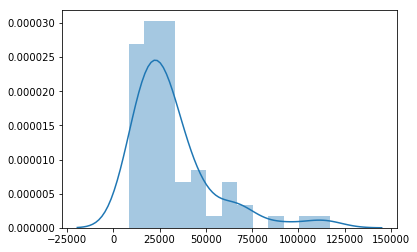

In [10]:
sns.distplot(microbe_counts.sum(axis=0))

In [11]:
microbe_props = microbe_counts.apply(lambda x: x / x.sum(), axis=0)

In [12]:
microbe_props = microbe_props.loc[microbes['#SampleID']].T

In [13]:
mean_microbe_abundance = np.log(microbe_props.mean(axis=0))

In [14]:
norm_microbe_abundance = (mean_microbe_abundance -  mean_microbe_abundance.min()) / (mean_microbe_abundance.max() - mean_microbe_abundance.min())

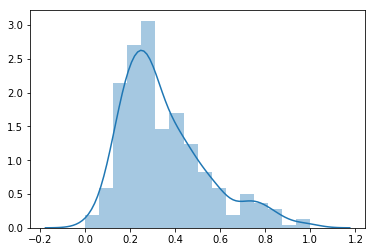

In [15]:
fontmin = 8
fontmax = 30

fontsize = norm_microbe_abundance * (fontmax - fontmin) + fontmin

sns.distplot(norm_microbe_abundance)

In [16]:
# scrub edges, because of R ...
edges['src'] = edges.src.apply(lambda x: int(x.replace('\"', '')))
edges['dest'] = edges.dest.apply(lambda x: x.replace('\"', ''))

In [17]:
select_microbes = list(set(edges.src.values))
select_kegg = list(set(edges.dest.values))

Text(0.5,1,'C(Advanced_Stage_label)[T.Local]')

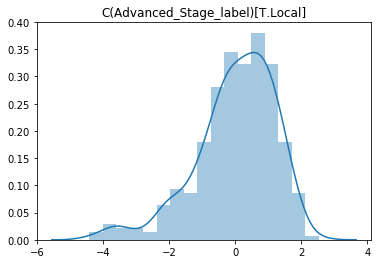

In [18]:
vals = microbes.set_index(featureid).loc[select_microbes, d_col]
sns.distplot(vals.dropna().values)
plt.title(d_col)

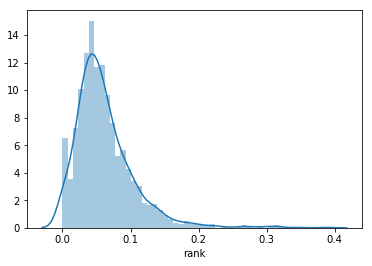

In [19]:
sns.distplot(edges['rank'])

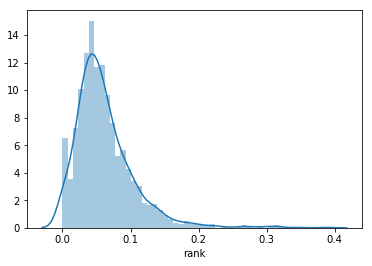

In [20]:
sns.distplot(edges[ew])

In [21]:
def abbreviate(x):
    return x.split('|')[-1]
abbreviate('k__Viruses|p__Viruses_noname|c__Viruses_noname|o__Viruses_noname')

'o__Viruses_noname'

In [22]:
microbe_dicts = microbes.T.to_dict().values()
kegg_dicts = keggs.T.to_dict().values()
edge_dicts = edges.T.to_dict().values()

In [23]:
microbe_metadata = microbes.set_index('#SampleID')

In [24]:
# name abbreviation mappings.
def abbreviate(d):
    return '%s%d' % (d[taxa_level], d[featureid])

def microbe_name_dict(dicts):
    return dict([abbreviate(d), d] for d in dicts)

name2microbe = microbe_name_dict(microbe_dicts)
name2microbe.items()[15]

('g__1081815',
 {'#SampleID': 1081815,
  'C(Advanced_Stage_label)[T.Local]': 0.280803757,
  'C(Advanced_Stage_label)[T.n.a]': -0.39687682,
  'C(Smoking_status)[T.Current]': 0.122924215,
  'C(Smoking_status)[T.Former]': -0.556633833,
  'C(Smoking_status)[T.Never]': 1.897413645,
  'C(Smoking_status)[T.current]': -0.971688392,
  'Intercept': 0.135780182,
  'Rank1': 'k__Bacteria',
  'Rank2': 'p__Actinobacteria',
  'Rank3': 'c__Actinobacteria',
  'Rank4': 'o__Actinomycetales',
  'Rank5': 'f__Micrococcaceae',
  'Rank6': 'g__',
  'Rank7': 's__'})

In [25]:
def kegg_name_dict(dicts):
    return dict([d['#OTUID'], d] for d in dicts)

In [26]:
name2kegg = kegg_name_dict(kegg_dicts)
name2kegg.items()[32]

('Competence-related_DNA_transformation_transporter_(DNA-T)_core_components',
 {'#OTUID': 'Competence-related_DNA_transformation_transporter_(DNA-T)_core_components',
  'Interest': 'N'})

In [27]:
# Construct the network graph from the edges.
from jp_gene_viz import dGraph
G = dGraph.WGraph()
for e in edge_dicts:
    name = '%s%d' % (microbe_metadata.loc[e["src"], taxa_level], e["src"])
    G.add_edge(name, e["dest"], e[ew], e)

In [28]:
# Construct the network widget from the graph
from jp_gene_viz import dNetwork
dNetwork.load_javascript_support()
N = dNetwork.NetworkDisplay()
N.load_data(G)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
import matplotlib.colors as colors
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))


In [30]:
import matplotlib as mpl
from matplotlib.colors import rgb2hex
# TODO: make parameter
# https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
#cmap = plt.get_cmap('RdYlGn')
cmap = plt.get_cmap('PiYG')
microbe_norm = MidpointNormalize(vmin=-2., vcenter=0, vmax=1.5)
#microbe_norm = mpl.colors.Normalize(vmin=0, vmax=1)
kegg_norm = mpl.colors.Normalize(vmin=-2, vmax=2)

In [31]:
# Configure and display the network

# TODO: remove congested labels
N.labels_button.value = True
N.size_slider.value = 1000

# TODO: add node size / font size are variable features
# TODO: swap circles with squares
# TODO: light grey dashed lines for low probability edges
# TODO: add edge weight size
# TODO: remove labels programmatically
# TODO: allow for edges to be colored on a gradient (i.e. greys)

# main goals
# 1. focus on pathways of interest
# 2. advance vs local
# 3. weighted by relative abundance

# colorize the nodes based on weights (hacky, sorry)
dg = N.display_graph
for node_name in dg.node_weights:
    svg_name = dg.node_name(node_name)

    if node_name in name2microbe:
        d = name2microbe[node_name]
        value = name2microbe[node_name][d_col]        
        if np.isnan(value):
            value = 0        
        node_color = rgb2hex(cmap(microbe_norm(value))[:3])      
        
        value = norm_microbe_abundance.loc[d['#SampleID']]
        #node_color = rgb2hex(cmap(microbe_norm(value))[:3])   
        
        N.override_node(node_name, color=node_color, radius=value*10, shape='circle')
        N.override_label(node_name, hide=value < 0.3, font_size=value*18)
        
    else:
        N.override_node(node_name, shape='rect')
    
# show labels
N.labels_button.value = True

# rerun the layout
N.layout_click()
    
# draw the network with the new colors and sizes
N.draw()

# show the network
N.show()

SEJveChjaGlsZHJlbj0oVkJveChjaGlsZHJlbj0oRHJvcGRvd24obGF5b3V0PUxheW91dCh3aWR0aD11JzE1MHB4JyksIG9wdGlvbnM9KCdTVkcnLCAnY2FudmFzJyksIHZhbHVlPSdTVkcnKSzigKY=


In [32]:
node_color

u'#5ea02c'

In [33]:
cmap(microbe_norm(value))

(0.7534025374855826, 0.8961937716262977, 0.5767012687427916, 1.0)

In [34]:
cmap(microbe_norm(-2))

(0.5568627450980392, 0.00392156862745098, 0.3215686274509804, 1.0)